In [1]:
library(dplyr)
library(tidyr)
library(ggsci)
library(lfe)
library(fixest)
library(stringr)
library(ggplot2)
library(doMC)
registerDoMC(18)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [2]:
df <- data.table::fread('/pool001/mfzhao/PROCESSED_DATA/dyadic_mvmt_2020.csv')

In [3]:
df %>% 
    filter(origin_cluster != destination_cluster) %>%
    mutate(oRain  = as.numeric(oPRCP > 0),
           dRain  = as.numeric(dPRCP > 0),
           nearby = as.numeric(dist < 100)) -> df

In [4]:
cns <- colnames(df)
cns

[1] "date"                "dyad"                "origin_cluster"     
 [4] "destination_cluster" "n"                   "bordering"          
 [7] "ndotd"               "pdotd"               "dist"               
[10] "oPRCP"               "oTMAX"               "oprcp01"            
[13] "oprcp02"             "oprcp03"             "oprcp04"            
[16] "oprcp05"             "oprcp06"             "oprcp07"            
[19] "oprcp08"             "oprcp09"             "oprcp10"            
[22] "otmax02"             "otmax03"             "otmax04"            
[25] "otmax05"             "otmax06"             "otmax07"            
[28] "otmax08"             "otmax09"             "otmax10"            
[31] "dPRCP"               "dTMAX"               "dprcp01"            
[34] "dprcp02"             "dprcp03"             "dprcp04"            
[37] "dprcp05"             "dprcp06"             "dprcp07"            
[40] "dprcp08"             "dprcp09"             "dprcp10"            
[43] "dtmax02"             "dtmax03"             "dtmax04"            
[46] "dtmax05"             "dtmax06"             "dtmax07"            
[49] "dtmax08"             "dtmax09"             "dtmax10"            
[52] "onewcases"           "onewdeaths"          "ostnewcases"        
[55] "ostnewdeaths"        "oct_unemp_rate"      "ost_unemp_rate"     
[58] "oas_newcases"        "oas_newdeaths"       "oas_stnewcases"     
[61] "oas_stnewdeaths"     "dnewcases"           "dnewdeaths"         
[64] "dstnewcases"         "dstnewdeaths"        "dct_unemp_rate"     
[67] "dst_unemp_rate"      "das_newcases"        "das_newdeaths"      
[70] "das_stnewcases"      "das_stnewdeaths"     "op1"                
[73] "op2"                 "op3"                 "dp1"                
[76] "dp2"                 "dp3"                 "op1:dp1"            
[79] "op1:dp2"             "op1:dp3"             "op2:dp1"            
[82] "op2:dp2"             "op2:dp3"             "op3:dp1"            
[85] "op3:dp2"             "op3:dp3"             "oRain"              
[88] "dRain"               "nearby"

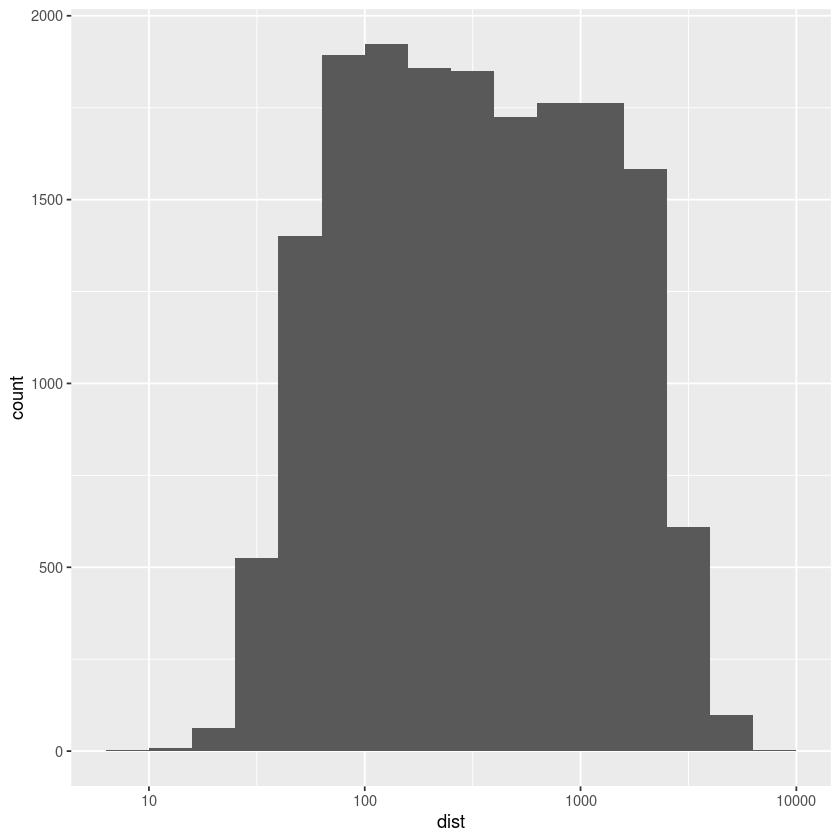

In [5]:
df %>%
    select(dyad, dist) %>%
    distinct()%>%
    ggplot(aes(x = dist)) +
    geom_histogram(binwidth = 0.2, center = 0.1) +
    scale_x_log10()

In [6]:
wctrls  <- str_c(cns[str_detect(cns, '[od][pt][rm][ca][px]..')], collapse = ' + ')
cdctrls <- str_c(cns[str_detect(cns, '[od][acs][st]_')], collapse = ' + ')
ctrls   <- str_c(wctrls, ' + ', cdctrls)

In [69]:
get_coefs <- function(dv, type) {
    if(type == 'all') {
        temp <- df
    } else {
        temp <- df %>%
            filter(nearby == ifelse(type == 'nearby', 1, 0))
    }
    
    if(dv == 'ndotd') {
        form <- str_c('log(ndotd) ~ op1 + op2 + op3 + dp1 + dp2 + dp3 + ', ctrls, ' | dyad + date')
        fit  <- feols(as.formula(form), temp, nthread = 20)
    } else {
        form <- str_c('log(pdotd) ~ op1 + op2 + op3 + dp1 + dp2 + dp3 + ', ctrls, ' | dyad + date')
        fit  <- feols(as.formula(form), temp, weights = temp$n, nthread = 20)
    }

    out <- summary(fit)$coeftable %>%
        mutate(var  = rownames(.),
               dv   = dv, 
               type = type) %>%
        rename(estimate = Estimate, se = `Std. Error`)
    
    return(out)
}

get_coefs('ndotd', 'nearby')

ERROR: Error in stri_c(..., sep = sep, collapse = collapse, ignore_null = TRUE): object 'lnl' not found


In [9]:
foreach(dv = c('ndotd', 'pdotd'), .combine = rbind) %:%
    foreach(type = c('all', 'nearby', 'distant'), .combine = rbind) %do%
    get_coefs(dv, type) -> dyad_coefs

NOTE: 24,388 observations removed because of NA values (RHS: 24,388).

NOTE: 9,464 observations removed because of NA values (RHS: 9,464).

NOTE: 14,924 observations removed because of NA values (RHS: 14,924).

NOTE: 24,388 observations removed because of NA values (RHS: 24,388).

NOTE: 9,464 observations removed because of NA values (RHS: 9,464).

NOTE: 14,924 observations removed because of NA values (RHS: 14,924).



In [67]:
dyad_coefs

estimate,se,t value,Pr(>|t|),var,dv,type
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
-0.038925762,0.006218735,-6.2594336,3.956702e-10,op1,ndotd,all
0.001162967,0.005890492,0.1974313,8.434924e-01,op2,ndotd,all
0.018247100,0.004838481,3.7712458,1.629868e-04,op3,ndotd,all
-0.017932105,0.005835059,-3.0731657,2.121372e-03,dp1,ndotd,all
-0.022680031,0.006513667,-3.4819147,4.990971e-04,dp2,ndotd,all
0.054210368,0.004706203,11.5189191,1.377123e-30,dp3,ndotd,all
-0.015523494,0.007975464,-1.9464064,5.167876e-02,op1,ndotd,nearby
-0.052802380,0.008561723,-6.1672610,7.666907e-10,op2,ndotd,nearby
0.029848001,0.006459692,4.6206541,3.950835e-06,op3,ndotd,nearby


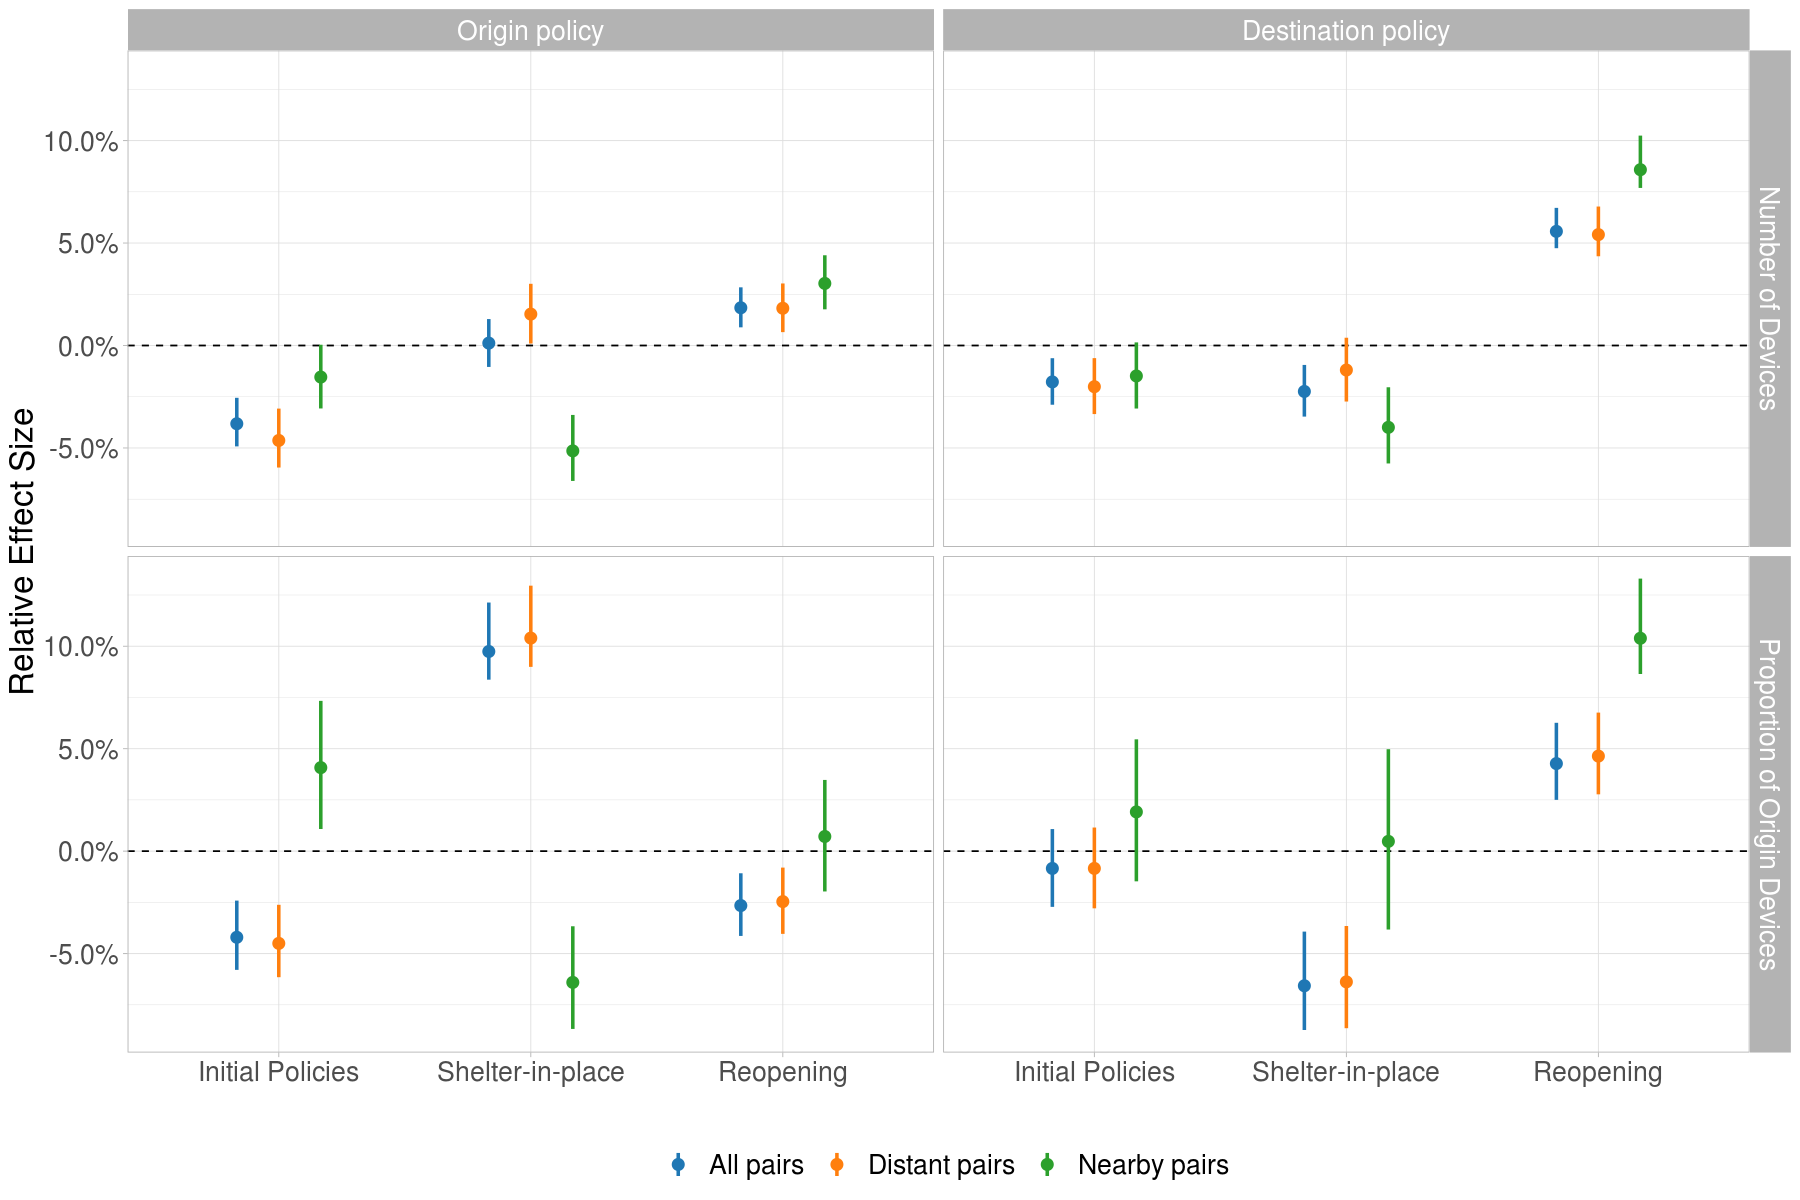

In [36]:
options(repr.plot.width=15, repr.plot.height=10)
dyad_coefs %>%
    mutate(od = ifelse(str_detect(var, 'op'), 'Origin policy', 'Destination policy'),
           od = factor(od, c('Origin policy', 'Destination policy')),
           var = ifelse(str_detect(var, 'p1'), 'Initial Policies', 
                        ifelse(str_detect(var, 'p2'), 'Shelter-in-place', 'Reopening')),
           var = factor(var, levels = c('Initial Policies', 'Shelter-in-place', 'Reopening')),
           dv  = ifelse(dv == 'ndotd', 'Number of Devices', 'Proportion of Origin Devices'),
           estimate = exp(estimate) - 1,
           u95ci    = exp(estimate + 1.98 * se) - 1,
           l95ci    = exp(estimate - 1.98 * se) - 1) %>%
    ggplot(aes(x = var, y = estimate, color = type)) + 
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(0.5), size = 3) +
    geom_linerange(aes(ymin = l95ci, ymax = u95ci), 
                   position = position_dodge(0.5), size = 1) +
    xlab('') + 
    ylab('Relative Effect Size') +
    labs(color = '') + 
    scale_color_d3(labels = c('All pairs', 'Distant pairs', 'Nearby pairs')) + 
    scale_y_continuous(labels = scales::percent) +
    facet_grid(dv ~ od, scales = 'free_x') +
    theme_light() +
    theme(text = element_text(size=20),
          legend.position = 'bottom') -> p
p
ggsave('/home/mfzhao/p5.pdf', p, device = 'pdf', width = 6.5, height = 5, scale = 2)

In [18]:
df %>%
    mutate(o  = ifelse(op3 == 1, 'p3',
                       ifelse(op2 == 1, 'p2', 
                              ifelse(op1 == 1, 'p1', 'p0'))),
           dp0 = 1) -> df.opmex

df.opmex %>%
    select(date, dyad, origin_cluster, destination_cluster, n, nearby, bordering, dist, ndotd, pdotd, 
           matches('unemp'), 
           matches('[od]prcp[01][0-9]'), 
           matches('[od]tmax[01][0-9]'), 
           matches('[od]as_')) %>%
    bind_cols(as.data.frame(model.matrix(ndotd ~ 0 + o * (dp0 + dp1 + dp2 + dp3), df.opmex))) %>%
    mutate(`op0:dp0` = op0 * dp0,
           `op0:dp1` = op0 * dp1,
           `op0:dp2` = op0 * dp2,
           `op0:dp3` = op0 * dp3) -> df.opmex

colnames(df.opmex) <- str_replace(colnames(df.opmex), ':', '_')

In [19]:
df %>%
    select(dyad, date, op1, op2, op3, dp1, dp2, dp3) %>%
    mutate(op = ifelse(op3 == 1, 3,
                       ifelse(op2 == 1, 2, 
                              ifelse(op1 == 1, 1, 0))),
           dp = ifelse(dp3 == 1, 3,
                       ifelse(dp2 == 1, 2, 
                              ifelse(dp1 == 1, 1, 0)))) %>%
    group_by(op, dp) %>%
    tally()

op,dp,n
<dbl>,<dbl>,<int>
0,0,1262386
0,1,25853
0,2,754
1,0,25956
1,1,150782
1,2,66973
1,3,3699
2,0,954
2,1,70416


In [20]:
get_coefs2 <- function(dv, type) {
    if(type == 'all') {
        temp <- df.opmex
    } else {
        temp <- df.opmex %>%
            filter(nearby == ifelse(type == 'nearby', 1, 0))
    }
    
    if(dv == 'ndotd') {
        form <- str_c('log(ndotd) ~ op1 + op2 + op0_dp1 + op0_dp2 + op1_dp1 + op1_dp2 + op1_dp3 +
                          op2_dp1 + op2_dp2 + op2_dp3 + op3_dp1 + op3_dp2 + op3_dp3 + ', ctrls, ' | dyad + date')
        fit  <- feols(as.formula(form), temp, nthread = 20)

    } else {
        form <- str_c('log(pdotd) ~ op1 + op2 + op0_dp1 + op0_dp2 + op1_dp1 + op1_dp2 + op1_dp3 +
                          op2_dp1 + op2_dp2 + op2_dp3 + op3_dp1 + op3_dp2 + op3_dp3 + ', ctrls, ' | dyad + date')
        fit  <- feols(as.formula(form), temp, weights = temp$n, nthread = 20)
    }
    
    out <- summary(fit)$coeftable %>%
        mutate(var  = rownames(.),
               dv   = dv, 
               type = type) %>%
        filter(str_detect(var, '[od]p[123]')) %>%
        rename(estimate = Estimate, se = `Std. Error`)
    
    return(out)
}

In [21]:
foreach(dv = c('ndotd', 'pdotd'), .combine = rbind) %:%
    foreach(type = c('all', 'nearby', 'distant'), .combine = rbind) %do%
    get_coefs2(dv, type) -> dyad_coefs2

NOTE: 24,388 observations removed because of NA values (RHS: 24,388).

NOTE: 9,464 observations removed because of NA values (RHS: 9,464).

NOTE: 14,924 observations removed because of NA values (RHS: 14,924).

NOTE: 24,388 observations removed because of NA values (RHS: 24,388).

NOTE: 9,464 observations removed because of NA values (RHS: 9,464).

NOTE: 14,924 observations removed because of NA values (RHS: 14,924).



Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 12 rows [1, 2, 13, 14, 25, 26, 37, 38, 49, 50, 61, 62].”
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



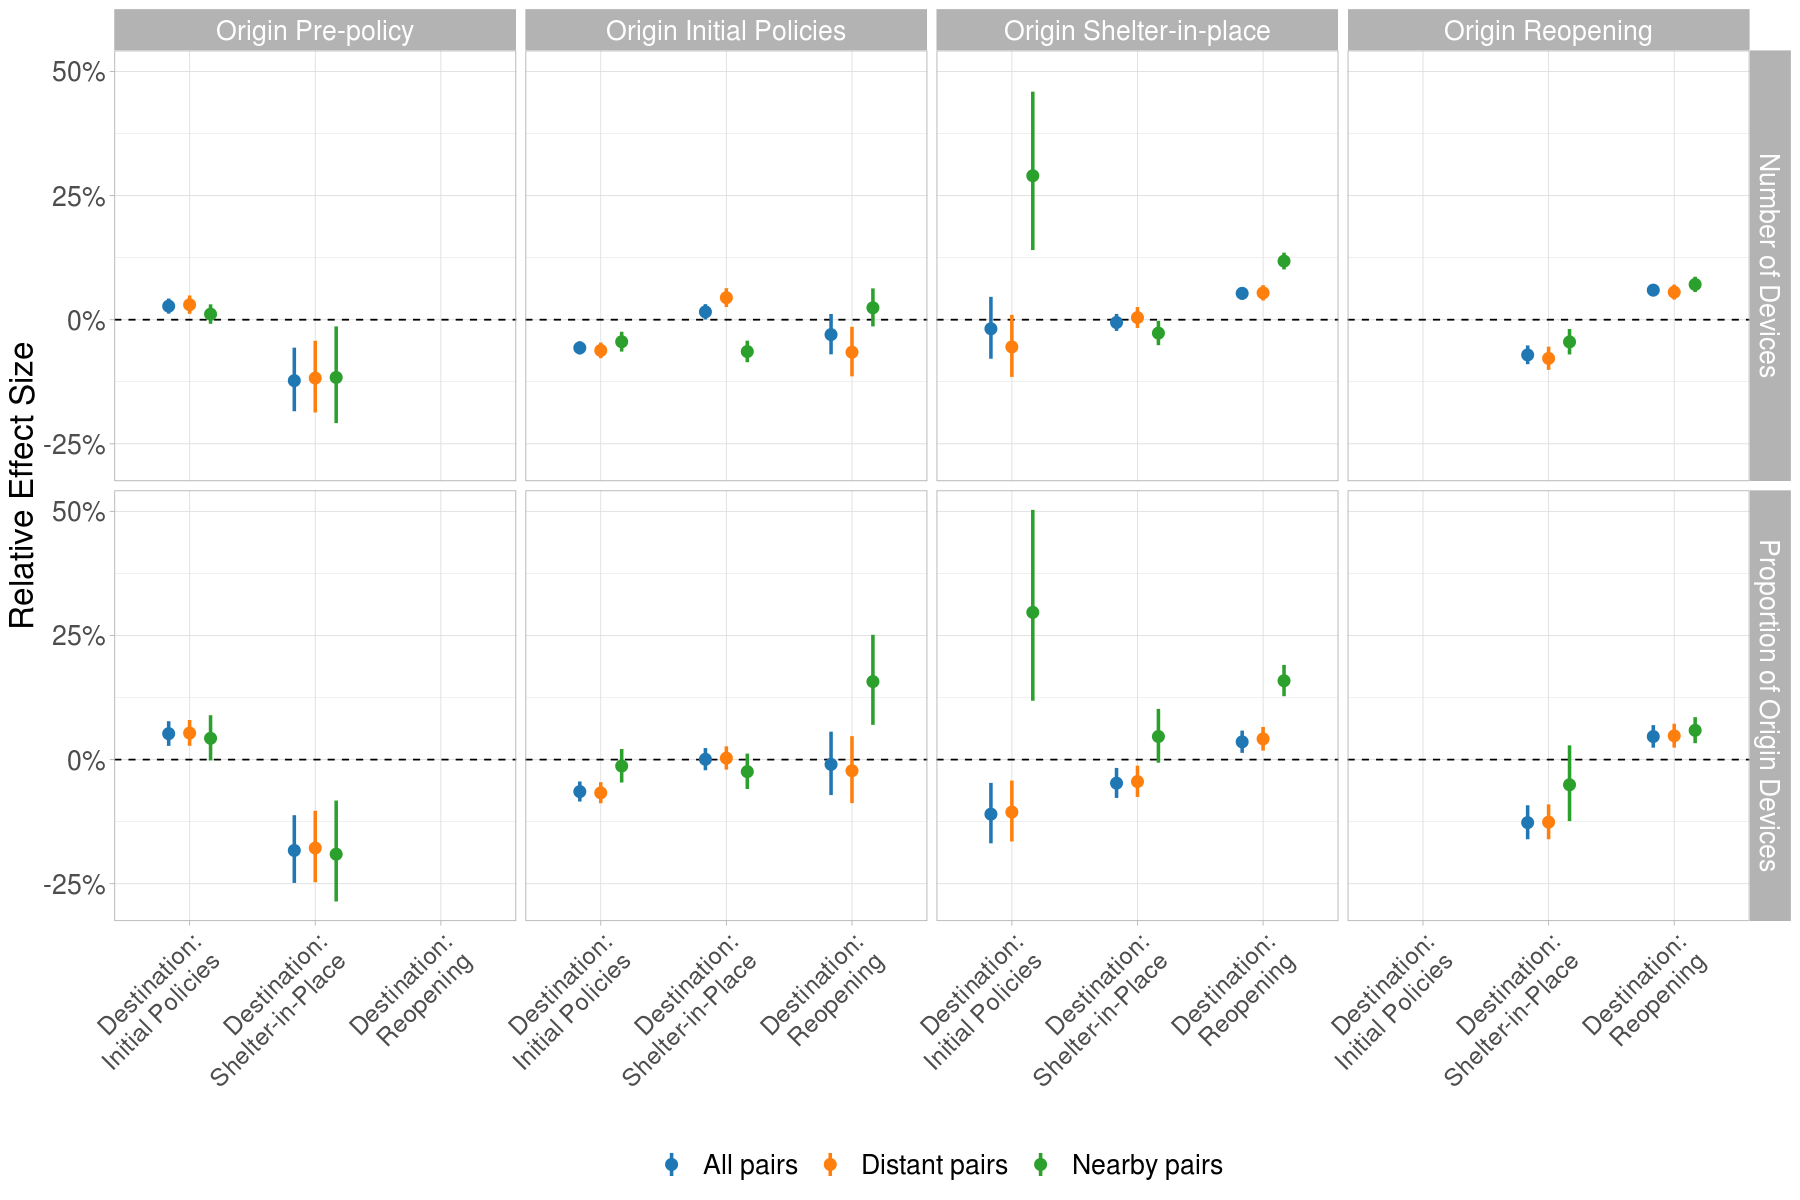

In [66]:
pn <- c('op0'   = "Origin Pre-policy",
        'op1'   = "Origin Initial Policies",
        'op2'   = "Origin Shelter-in-place",
        'op3'   = "Origin Reopening",
        'ndotd' = 'Number of Devices',
        'pdotd' = 'Proportion of Origin Devices')

dyad_coefs2 %>%
    filter(var != 'op3_dp1') %>%
    separate(var, into = c('origin policy', 'destination policy')) %>%
    mutate(`destination policy` = ifelse(str_detect(`destination policy`, 'p1'), 'D:(ip)', 
                                        ifelse(str_detect(`destination policy`, 'p2'), 'D:(sh)', 'D:(ro)')),
           `destination policy` = factor(`destination policy`, levels = c('D:(ip)', 'D:(sh)', 'D:(ro)'))) %>%
    mutate(u95ci    = exp(estimate + 1.98 * se) - 1,
           l95ci    = exp(estimate - 1.98 * se) - 1, 
           estimate = exp(estimate) - 1) %>%
    filter(!is.na(`destination policy`)) %>%
    ggplot(aes(x = `destination policy`, y = estimate, color = type)) + 
    geom_hline(aes(yintercept = 0), linetype = 2) +
    geom_point(position = position_dodge(0.5), size = 3) +
    geom_linerange(aes(ymin = l95ci, ymax = u95ci), 
                   position = position_dodge(0.5), size = 1) +
    scale_color_d3() +
    xlab('') + 
    ylab('Relative Effect Size') +
    labs(color = '') + 
    scale_color_d3(labels = c('All pairs', 'Distant pairs', 'Nearby pairs')) + 
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c('Destination:\nInitial Policies',
                                'Destination:\nShelter-in-Place',
                                'Destination:\nReopening')) + 
    facet_grid(dv ~ `origin policy`, labeller = as_labeller(pn)) +
    theme_light() +
    theme(text = element_text(size=20),
          axis.text.x = element_text(angle = 45, 
                                     size = 15,
                                     hjust = 1,
                                     vjust = 1),
          legend.position = 'bottom') -> p

ggsave('/home/mfzhao/p6.pdf', p, device = 'pdf', width = 6.5, height = 5, scale = 2)

p

In [65]:
dyad_coefs2 %>%
    mutate(estimate = exp(estimate) - 1) %>%
    filter(var == 'op3_dp3') %>%
    filter(type == 'nearby')

estimate,se,t value,Pr(>|t|),var,dv,type
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.07100266,0.007275252,9.428576,6.977776e-21,op3_dp3,ndotd,nearby
0.05893571,0.012538385,4.567124,5.099675e-06,op3_dp3,pdotd,nearby


In [ ]:
dyad_coefs2 %>%
    filter(var == 'op2_dp3') %>%
    filter(type == 'distant') %>%
    mutate(est = exp(estimate) - 1)